# Test the thermal emission and absorption modules

... by starting with a thermal distribution in equilibrium, checking that the system does not evolve from this.

In [51]:
%reset
import numpy as np
import sys
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

%run constants.ipynb
sys.path.append('../src/')
from core import SimulationManager

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


### Pre-run functionalities: Calculate Grid parameters from minimum and maximum energy

In [52]:
def calculate_grid_parameters(xmin, xmax, ulim_lastbin):
    D_X = np.log(1/(1-ulim_lastbin/xmax))
    X_I = np.log(xmin)/D_X
    BIN_X = np.log(xmax)/D_X - X_I
    return D_X, int(X_I), int(BIN_X)

In [53]:
def calculate_grid_parameters_DX(xmin, xmax, D_X):
    X_I = np.log(xmin)/D_X
    BIN_X = np.log(xmax)/D_X - X_I
    return int(X_I), int(BIN_X)

# Run the simulation

## Grid settings

In [55]:
xmin = 1.e-9
xmax = 1.e1

D_X = 4.e-2
X_I, BIN_X = calculate_grid_parameters_DX(xmin, xmax, D_X)
print(D_X, X_I, BIN_X)


0.04 -518 575


In [56]:
delta_t = 2.e-11

In [57]:
grid_parameters = {'BIN_X':BIN_X, 'D_X':D_X, 'X_I':X_I, 'type_grid' : 'log'}
solver_settings = {'include_kompaneets': False, 'kompaneets_extended_by': 'none', 'CN_solver': False }

## Initialize simulation and set parameters

In [58]:
sim = SimulationManager(grid_parameters, delta_t, solver_settings)

In [59]:

initial_array = np.zeros(BIN_X)

In [60]:
T = 10.e3/ k_B_eV

In [61]:
sim.source_parameters['T']=T *k_B_erg/ m_e/c0**2
sim.source_parameters['n_e'] = 6.e20
sim.source_parameters['bprime'] = 1.e4


In [62]:
sim.delta_t = 1.e-2 /(sim.source_parameters['n_e']*sigma_t*c0)

## Define initial black-body distribution

In [63]:
for k in range(BIN_X):
    x = sim.energygrid[k]
    lgr = x/sim.source_parameters['T']
    #if np.abs(lgr) < 1.e-10: 
    #    print(x)
    #    lgr = 1.e-10
    initial_array[k] = 1/(np.exp(lgr)-1)

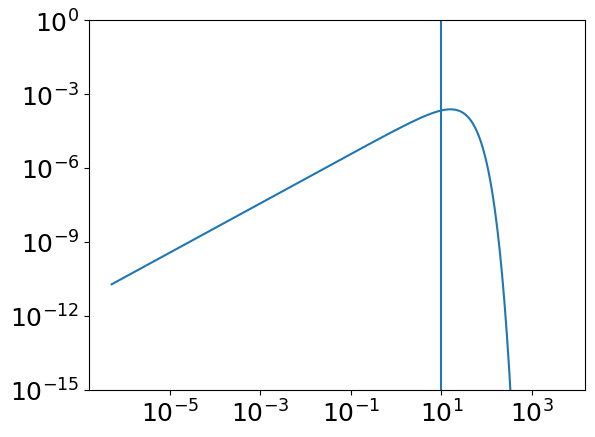

In [64]:
fig = plt.figure()

plt.plot(sim.energygrid*511, initial_array*sim.energygrid**2)
ax = plt.gca()
ax.set(yscale = 'log', xscale='log', ylim = [1.e-15, 1.e0])
ax.axvline(sim.source_parameters['T']*511)

plt.show()

## Initialize run with initial array, add modules

In [65]:
sim.initialise_run(initial_array)
modules = [('bremsstrahlung','Bremsstrahlung'), ('doublecompton', 'DoubleCompton'), ('cyclotron', 'Cyclotron')]

sim.reset_modules(modules)

## Run

In [66]:
photon_temp_evolution = []
temperature_evolution = []

In [67]:
for j in range(1000):
    clear_output(wait=True)
    sim.evolve_one_timestep()
    temperature_evolution.append(sim.source_parameters['T'])
    photon_temp_evolution.append(sim.photonarray)
    

# Plot

## Photon spectra
### Time evolution

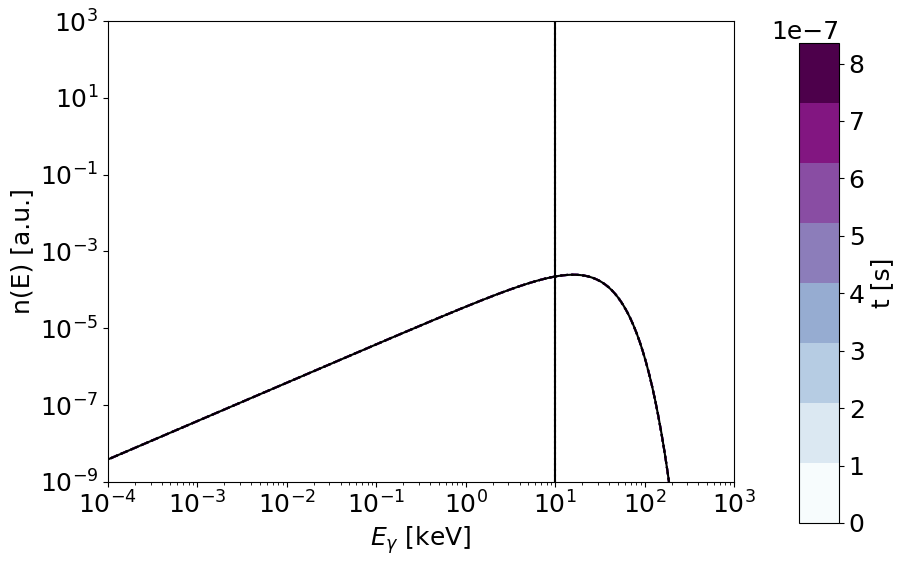

In [82]:
matplotlib.rcParams.update({'font.size': 18})

n_plots = 8

fig = plt.figure(figsize = [8, 6])

ax = plt.gca()
stepwidth = int(len(photon_temp_evolution)/n_plots)
colors = sns.color_palette('BuPu', n_plots)
for k in range(8):
    ax.plot(sim.energygrid*511, photon_temp_evolution[0:-1:stepwidth][k]*sim.energygrid**2,
             ls = '--', c = colors[k])
    
ax.plot(sim.energygrid*511, sim.photonarray*sim.energygrid**2, color = 'k')

ax.plot(sim.energygrid*511, initial_array*sim.energygrid**2, ls = ':', 
         color = 'k')

ax.axvline(10., color = 'k', ls = ':')
ax.axvline(sim.source_parameters['T']*511, color = 'k', ls = '-')

ax.set(yscale = 'log', xscale = 'log', 
       xlim = [1.e-4, 1.e3], ylim = [1.e-9, 1.e3],
      xlabel =r'$E_{\gamma}$ [keV]',
      ylabel = 'n(E) [a.u.]')

fig.tight_layout()

cbar_ax = fig.add_axes([1.02, 0.1, 0.05, 0.8])

norm = matplotlib.colors.Normalize(vmin=0, vmax=sim.time)
cmap = matplotlib.colormaps['BuPu'].resampled(n_plots)

cbar = matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm = norm, label = r't [s]', 
                         orientation = 'vertical')


plt.show()

### Full-range specta

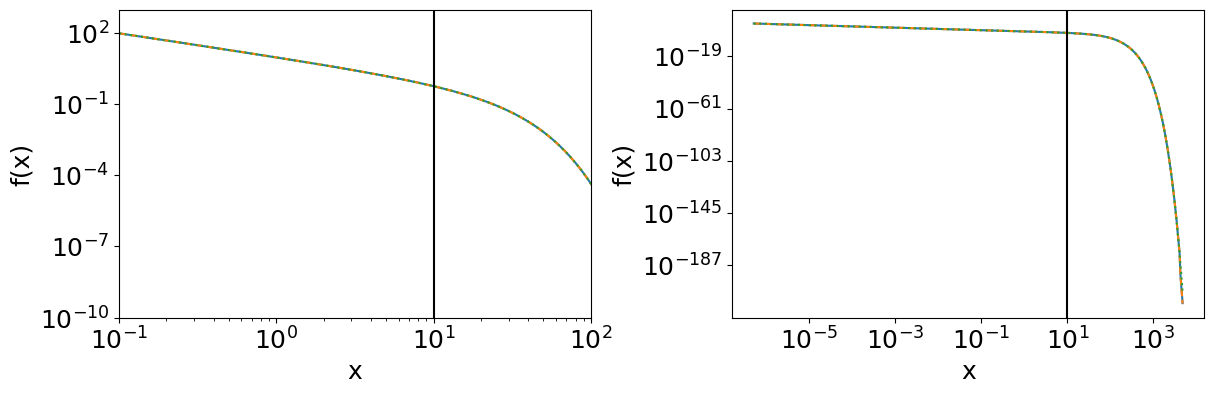

In [83]:
fig, axes = plt.subplots(1,2, figsize = [14, 4])
plt.subplots_adjust(wspace = 0.3)
ax = axes[0]
ax.plot(sim.energygrid*511, sim.photonarray)
ax.plot(sim.energygrid*511, photon_temp_evolution[int(len(photon_temp_evolution)/2)], ls = '--')

ax.plot(sim.energygrid*511, initial_array, ls = ':')
ax.axvline(sim.source_parameters['T'] *511, color = 'k')
ax.set(yscale = 'log', xscale = 'log', 
       xlim = [1.e-1, 1.e2], ylim = [1.e-10, 1.e3], xlabel = 'x', ylabel = 'f(x)')


ax = axes[1]

ax.plot(sim.energygrid*511, sim.photonarray)
ax.plot(sim.energygrid*511, photon_temp_evolution[int(len(photon_temp_evolution)/2)], ls = '--')

ax.plot(sim.energygrid*511, initial_array, ls = ':')
ax.axvline(sim.source_parameters['T']*511, color = 'k')
ax.set(yscale = 'log', xscale = 'log', xlabel = 'x', ylabel = 'f(x)')

#ax.set(yscale = 'log', xscale = 'log', xlim = [1.e-12, 1.e3], ylim = [1.e-14, 1.e3])
plt.show()

## Injection and cooling rates

In [84]:
brems_cooling = sim.get_coolingrate('Bremsstrahlung')
ad_cooling = sim.get_coolingrate('Adiabatic')
dc_cooling = sim.get_coolingrate('DoubleCompton')
cy_cooling = sim.get_coolingrate('Cyclotron')
ad_aterm = sim.get_aterm('Adiabatic')


In [85]:
brems_inj = sim.get_injectionrate('Bremsstrahlung')
ad_inj = sim.get_injectionrate('Adiabatic')
dc_inj = sim.get_injectionrate('DoubleCompton')
cy_inj = sim.get_injectionrate('Cyclotron')

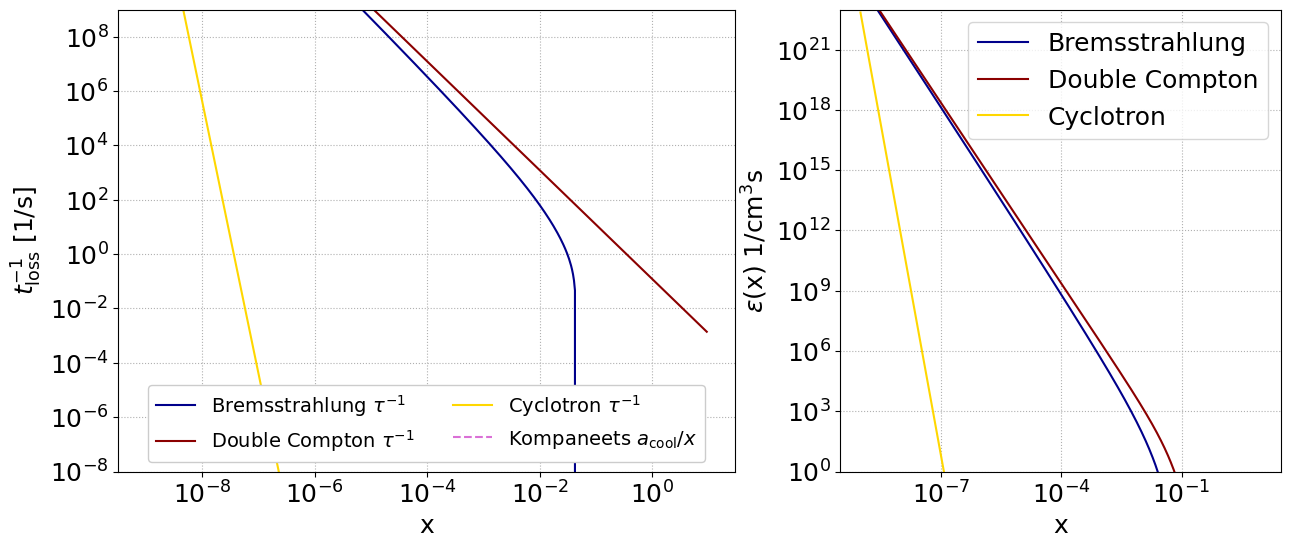

In [86]:
fig, axes = plt.subplots(1, 2, figsize = [15, 6], gridspec_kw={'width_ratios': [1.4, 1]})

ax = axes[0]
ax.plot(sim.energygrid, brems_cooling, ls = '-',  label = r'Bremsstrahlung $\tau^{-1}$', color = 'darkblue')
ax.plot(sim.energygrid, dc_cooling, ls = '-',  label = r'Double Compton $\tau^{-1}$', color = 'darkred')
ax.plot(sim.energygrid, cy_cooling, ls = '-',  label = r'Cyclotron $\tau^{-1}$', color = 'Gold')

ax.plot(sim.half_grid, sim.heating_term_kompaneets*sim.pre_factor_term[:-1]/sim.half_grid, 
        ls = '--', label = r'Kompaneets $a_\mathrm{cool} / x$', color = 'orchid')

ax.legend(ncol = 2, fontsize = 14, framealpha = 1.0, loc = 'lower center')
ax.set(xscale = 'log', yscale = 'log', ylim = [1.e-8, 1.e9])
ax.set(xlabel = 'x', ylabel = r'$t^{-1}_\mathrm{loss}$ [1/s]')
ax.grid(ls = ':')

ax = axes[1]

ax.plot(sim.energygrid, brems_inj, ls = '-', label = 'Bremsstrahlung', color = 'darkblue')
ax.plot(sim.energygrid, dc_inj, ls = '-', label = 'Double Compton', color = 'darkred')
ax.plot(sim.energygrid,cy_inj, ls = '-', label = 'Cyclotron', color = 'Gold')

ax.legend()
ax.set(xscale = 'log', yscale = 'log')
ax.set(ylim = [1.e0, 1.e23])
ax.set(xlabel = 'x', ylabel = r'$\epsilon$(x) 1/cm$^3$s')
ax.grid(ls = ':')
plt.show()

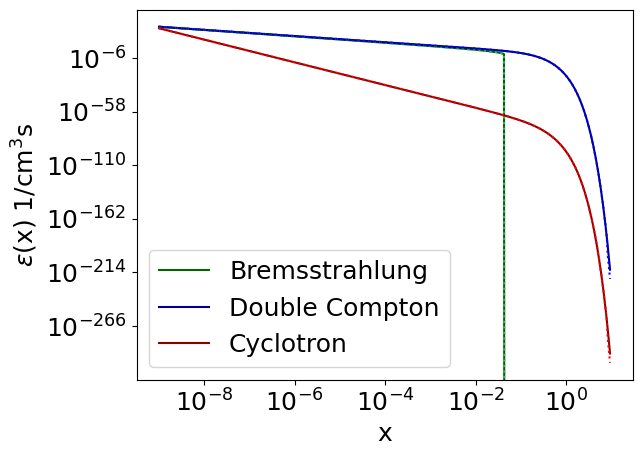

In [87]:
fig, ax = plt.subplots()
ax.plot(sim.energygrid, brems_inj, ls = '-', label = 'Bremsstrahlung', color = 'darkgreen')
ax.plot(sim.energygrid, dc_inj, ls = '-', label = 'Double Compton', color = 'darkblue')
ax.plot(sim.energygrid,cy_inj, ls = '-', label = 'Cyclotron', color = 'darkred')

ax.plot(sim.energygrid, brems_cooling*sim.photonarray, ls = ':', color = 'mediumseagreen')
ax.plot(sim.energygrid, dc_cooling*sim.photonarray, ls = ':', color = 'blue')
ax.plot(sim.energygrid, cy_cooling*sim.photonarray, ls = ':', color = 'red')


ax.legend()
ax.set(xscale = 'log', yscale = 'log')
#ax.set(ylim = [1.e0, 1.e23])
ax.set(xlabel = 'x', ylabel = r'$\epsilon$(x) 1/cm$^3$s')

plt.show()